 # Inspecting pickled `bigram` hits

 ## Imports

In [1]:
import pandas as pd
from pathlib import Path

 ## Define helper functions

 ### Copied from `./source/analyze/utils/`
 jupyter won't import them 🤷‍♀️

In [2]:
def find_files(data_dir: Path, fname_glob: str, verbose: bool = False):
    path_iter = data_dir.rglob(fname_glob)
    if verbose:
        path_iter = tuple(path_iter)
        print_iter(
            [f'../{p.relative_to(data_dir)}' for p in path_iter], bullet='-',
            header=f'### {len(path_iter)} paths matching {fname_glob} found in {data_dir}')
    return path_iter


def print_iter(iter_obj,
               bullet: str = '▸',
               # //    logger: logging.Logger = None,
               # //    level: int = 20,
               header: str = ''):

    bullet_str = f'\n{bullet} '

    iter_str = bullet_str.join(f'{i}' for i in iter_obj)

    msg_str = f'\n{header}{bullet_str}{iter_str}'
    msg_str = msg_str.replace('\n\n', '\n').strip(f'{bullet} ')

    print(msg_str)


def cols_by_str(df: pd.DataFrame, start_str=None, end_str=None) -> list:
    if end_str:
        cols = df.columns[df.columns.str.endswith(end_str)]
        if start_str:
            cols = cols[cols.str.startswith(start_str)]
    elif start_str:
        cols = df.columns[df.columns.str.startswith(start_str)]
    else:
        cols = df.columns

    return cols.to_list()


def make_cats(orig_df: pd.DataFrame, columns: list = None) -> pd.DataFrame:
    df = orig_df.copy()
    if columns is None:
        cat_suff = ("code", "name", "path", "stem")
        columns = df.columns.str.endswith(cat_suff)  # type: ignore
    df.loc[:, columns] = df.loc[:, columns].astype(
        'string').fillna('_').astype('category')

    return df


def balance_sample(full_df: pd.DataFrame,
                   column_name: str = 'category',
                   sample_per_value: int = 5,
                   verbose: bool = False) -> tuple:
    '''
    create sample with no more than n rows satisfying each unique value
    of the given column. A value of -1 for `sample_per_value` will limit
    all values' results to the minimum count per value.
    '''
    info_message = ''
    subsamples = []
    for __, col_val_df in full_df.groupby(column_name):
        # take sample if 1+ and less than length of full dataframe
        if len(col_val_df) > sample_per_value > 0:
            subsample_df = col_val_df.sample(sample_per_value)
            subsamples.append(subsample_df)
        else:
            subsamples.append(col_val_df)

    # > trim all "by column" sub dfs to length of shortest if -1 given
    if sample_per_value == -1:
        trim_len = int(min(len(sdf) for sdf in subsamples))
        subsamples = [sdf.sample(trim_len)
                      for sdf in subsamples]

    b_sample = pd.concat(subsamples)

    if verbose:
        subset_info_table = (
            b_sample
            .value_counts(subset=column_name)
            .to_frame(name='count')
            .assign(percentage=b_sample
                    .value_counts(column_name, normalize=True)
                    .round(2) * 100)
            .to_markdown())
        label = (full_df.hits_df_pkl[0].stem + ' '
                 if 'hits_df_pkl' in full_df.columns
                 else '')
        info_message = (f'\n## {column_name} representation in {label}sample\n'
                        + subset_info_table)

    return b_sample, info_message


def concat_pkls(data_dir: Path = Path('/share/compling/data/sanpi/2_hit_tables'),
                fname_glob: str = '*.pkl.gz',
                pickles=None,
                convert_dtypes=False,
                verbose: bool = True) -> pd.DataFrame:
    if not pickles:
        pickles = find_files(Path(data_dir), fname_glob, verbose)

    # tested and found that it is faster to assign `corpus` intermittently
    sep_dfs = []
    for p in pickles:
        df = (pd.read_pickle(p).assign(corpus=p.stem.rsplit('_', 2)[0]))
        df = df.loc[:, cols_by_str(
            df, end_str=('lemma', 'id', 'text', 'window',
                      'category', 'Pol', 'sent')) + cols_by_str(df, start_str=('corpus', 'lemma'))]
        df = df.convert_dtypes()

        dup_check_cols = cols_by_str(df, end_str=('text', 'id', 'sent'))
        df = (df.loc[~df.duplicated(subset=dup_check_cols), :])
        sep_dfs.append(df)
    
    c_df = pd.concat(sep_dfs)    
    dup_check_cols = cols_by_str(c_df, end_str=('text', 'id', 'sent'))
    c_df = (c_df.loc[~c_df.duplicated(subset=dup_check_cols), :])
    c_df = make_cats(c_df, (['corpus'] + cols_by_str(c_df, start_str=('nr', 'neg', 'adv'),
                                                 end_str=('lemma', 'form'))))

    return c_df

 ### copied from `./source/analyze_deps.py`:

In [3]:
def _optimize_df(df: pd.DataFrame) -> pd.DataFrame:

    # print('Original Dataframe:')
    # df.info(memory_usage='deep')

    # > drop unneeded string columns
    # was:
    #   for c in udf.cols_by_str(df, start_str=('context', 'text', 'sent_text', 'token')):
    for c in cols_by_str(df, start_str=('context', 'token', 'utt')):
        df.pop(c)

    # > select only non-`object` dtype columns
    relevant_cols = df.columns[~df.dtypes.astype(
        'string').str.endswith(('object'))]
    # limit df to `relevant_cols`
    df = df[relevant_cols]

    # > create empty dataframe with `relevant_cols` as index/rows
    df_info = pd.DataFrame(index=relevant_cols)

    df_info = df_info.assign(
        mem0=df.memory_usage(deep=True),
        dtype0=df.dtypes.astype('string'),
        defined_values=df.count(),
        unique_values=df.apply(pd.unique, axis=0).apply(len))
    df_info = df_info.assign(
        ratio_unique=(df_info.unique_values/df_info.defined_values).round(2))

    cat_candidates = df_info.loc[df_info.ratio_unique < 0.8,
                                 :].loc[df_info.dtype0 != 'category'].index.to_list()
    #was: catted_df = udf.make_cats(df.copy(), cat_candidates)
    catted_df = make_cats(df.copy(), cat_candidates)

    df_info = df_info.assign(dtype1=catted_df.dtypes,
                             mem1=catted_df.memory_usage(deep=True))
    df_info = df_info.assign(mem_change=df_info.mem1-df_info.mem0)
    print(df_info.sort_values(
        ['mem_change', 'ratio_unique', 'dtype0']).to_markdown())
    mem_improved = df_info.loc[df_info.mem_change < 0, :].index.to_list()
    for c in df.columns[~df.columns.isin(mem_improved)]:
        print(c, '\t', df.loc[:, c].dtype)
    df.loc[:, mem_improved] = catted_df.loc[:, mem_improved]
    print('Category Converted dataframe:')
    df.info(memory_usage='deep')

    return df

 ### Newly created

In [4]:
def show_counts(df, columns):
    return df.value_counts(columns).to_frame().rename(columns={0: 'count'})

def summarize_text_cols(tdf: pd.DataFrame):

    summary = tdf.describe().transpose()
    summary = summary.assign(top_percent=(
        ((pd.to_numeric(summary.freq) / len(tdf)))*100).round(2))
    summary = summary.rename(columns={'top': 'top_value', 'freq': 'top_freq'})

    return summary.convert_dtypes().sort_values('unique')

 ## Load Data

In [5]:
# ddf = concat_pkls(
#     data_dir=Path('/share/compling/data/sanpi/2_hit_tables'),
#     # fname_glob='bigram*hits.pkl.gz',
#     fname_glob='bigram-[AP]??[TV_]*hits.pkl.gz',
#     convert_dtypes=True)

def select_pickles():
    # HACK -- `with-context/` is temporary!
    pickle_dir = Path(
        '/share/compling/data/sanpi/2_hit_tables/')
    # > make dataframe to load smallest files first (for testing)
    pkl_df = pd.DataFrame(pickle_dir.rglob(
        'bigram-*hits.pkl.gz'), columns=['path'])
    pkl_df = pkl_df.assign(size=pkl_df.path.apply(lambda f: f.stat().st_size))
    pkl_df = pkl_df.sort_values('size')
    print(pkl_df.reset_index().astype('string').to_markdown())
    pkl_paths = pkl_df.path.to_list()
    return pkl_paths
hit_pkls = select_pickles()

|     |   index | path                                                                                            |      size |
|----:|--------:|:------------------------------------------------------------------------------------------------|----------:|
|   0 |      61 | /share/compling/data/sanpi/2_hit_tables/scoped/bigram-PccTe_with-relay_hits.pkl.gz              |     47450 |
|   1 |      43 | /share/compling/data/sanpi/2_hit_tables/scoped/bigram-PccVa_with-relay_hits.pkl.gz              |     47672 |
|   2 |      22 | /share/compling/data/sanpi/2_hit_tables/raised/bigram-PccVa_neg-raised_hits.pkl.gz              |     61657 |
|   3 |       0 | /share/compling/data/sanpi/2_hit_tables/raised/bigram-PccTe_neg-raised_hits.pkl.gz              |     61667 |
|   4 |      70 | /share/compling/data/sanpi/2_hit_tables/contig/bigram-PccTe_sans-relay_hits.pkl.gz              |    856805 |
|   5 |      71 | /share/compling/data/sanpi/2_hit_tables/contig/bigram-PccVa_sans-relay_hits.pkl.gz    

In [6]:
ddf = concat_pkls(pickles=hit_pkls, convert_dtypes=True)
# ddf = concat_pkls(pickles=hit_pkls[:50], convert_dtypes=True)

 ## Optimize DataFrame

In [7]:
odf = _optimize_df(ddf)

|             |        mem0 | dtype0   |   defined_values |   unique_values |   ratio_unique | dtype1   |        mem1 |   mem_change |
|:------------|------------:|:---------|-----------------:|----------------:|---------------:|:---------|------------:|-------------:|
| category    |  6103058472 | string   |         96873944 |               4 |           0    | category |    96874368 |  -6006184104 |
| hit_text    |  6808263640 | string   |         96873944 |         3639490 |           0.04 | category |   807802634 |  -6000461006 |
| adj_lemma   |  6186338271 | string   |         96873944 |          296746 |           0    | category |   415916423 |  -5770421848 |
| match_id    |  5938373341 | string   |         96873944 |           11234 |           0    | category |   194767195 |  -5743606146 |
| relay_lemma |  3879144479 | string   |           186895 |           12431 |           0.07 | category |   194806896 |  -3684337583 |
| neg_lemma   |    96875492 | category |         968739

In [8]:
columns = odf.columns[~odf.columns.isin(cols_by_str(
    odf, start_str=('dep_m', 'dep_n', 'dep_r', 'context')))].to_list()
columns.sort()
odf = odf.loc[:, columns]
len(odf) == len(ddf)

True

In [10]:
odf.loc[odf.corpus.str.contains('Pcc'), 'corpus_group'] = 'puddin'
odf.loc[odf.corpus.str.endswith(('Nyt1', 'Nyt2', 'Apw')), 'corpus_group'] = 'news'

general_counts = show_counts(odf, ['category', 'corpus_group'])
general_counts = general_counts.unstack().sort_values(('count', 'puddin'), ascending=False)  # type: ignore
general_counts

count          
corpus_group     news    puddin
category                       
advadj        8373717  84716865
contig         327977   3047385
raised          19952    201153
scoped          20081    166814

 ### Add `conllu_id` and drop unused columns

In [12]:
tdf = odf.assign(conllu_id=odf.sent_id.str.rsplit('_', 2).str.get(0).str.split(
    '.').str.get(0).astype('string').astype('category'))  # type: ignore
tdf = odf[cols_by_str(odf, end_str=('lemma', 'id', 'text', 'window',
                      'category', 'Pol')) + cols_by_str(odf, start_str=('corpus', 'lemma'))]
print(f'Total hits for all patterns: {len(tdf)}')


Total hits for all patterns: 96873944


KeyboardInterrupt: 

In [13]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96873944 entries, pcc_eng_test_3.00526_x35290_08:1-4-8-9 to nyt_eng_20000131_0559_14:5-6
Data columns (total 16 columns):
 #   Column        Dtype   
---  ------        -----   
 0   adj_lemma     category
 1   adv_lemma     category
 2   category      category
 3   colloc_id     string  
 4   hit_text      category
 5   match_id      category
 6   neg_lemma     category
 7   nr_lemma      category
 8   relay_lemma   category
 9   sent_id       string  
 10  sent_text     string  
 11  text_window   string  
 12  conllu_id     category
 13  corpus        category
 14  lemma_str     string  
 15  corpus_group  object  
dtypes: category(10), object(1), string(5)
memory usage: 7.2+ GB


Total bare collocations: 93090582
Total pattern hits (+ NegPol pattern overlap): 93114978
PosPol: 96% : 89331616 hits
NegPol: 04% : 3783362 hits


<AxesSubplot:ylabel='Density'>

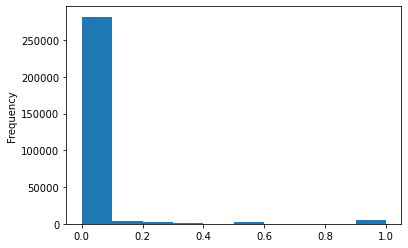

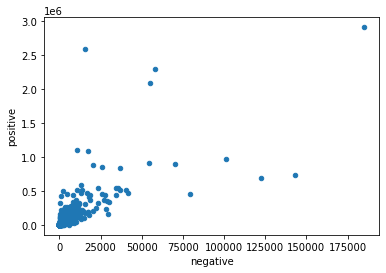

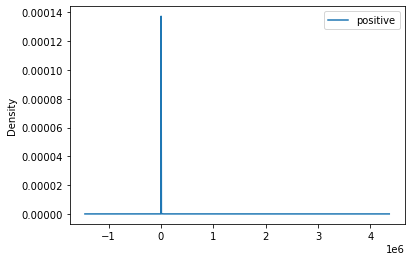

In [17]:
tdfn = tdf.loc[tdf.neg_lemma != '_', :]
# summarize_text_cols(tdfn)


## %%
tdfn[['neg_lemma', 'adv_lemma', 'adj_lemma', 'hit_text', 
      'text_window', 
    #   'sent_text'
      ]].sample(25)

## %%
tdfp = tdf.loc[~tdf.colloc_id.isin(tdfn.colloc_id), :]
# summarize_text_cols(tdfp)


## %% [markdown]
# ## Assign `polarity` and recombine

## %%
tdfp = tdfp.assign(polarity='positive')
tdfn = tdfn.assign(polarity='negative')
tdf_with_overlap = tdf
pol_union_df = pd.concat([tdfp, tdfn]).sort_values('colloc_id')

print(
    f'Total bare collocations: {odf.category.value_counts()["advadj"]}')
print(
    f'Total pattern hits (+ NegPol pattern overlap): {len(pol_union_df)}')
print(f'PosPol: {round(100*len(tdfp)/len(pol_union_df))}% : {len(tdfp)} hits')
print(
    f'NegPol: {str(round(100*len(tdfn)/len(pol_union_df))).zfill(2)}% : {len(tdfn)} hits')

top_200 = show_counts(pol_union_df, ['polarity', 'adj_lemma']).head(200)
top_200
top_200.to_csv('/share/compling/projects/sanpi/notebooks/bigram_out/top_200.csv')

top_200_neg = show_counts(pol_union_df.loc[pol_union_df.polarity=='negative', :], ['polarity', 'adj_lemma']).head(200)
top_200_neg
top_200_neg.to_csv('/share/compling/projects/sanpi/notebooks/bigram_out/top_200_neg.csv')

spread_top_200 = top_200.unstack(level='polarity', fill_value=0)
spread_top_200.sort_values(('count', 'negative'),
                           ascending=False).head(30)  # type: ignore

spread_top_200.sort_values(('count', 'positive'),
                           ascending=False).head(30)  # type: ignore

freq_dist = pd.crosstab(pol_union_df.adj_lemma,
                        pol_union_df.polarity,
                        margins=True, margins_name='TOTAL')

freq_dist = freq_dist.assign(
    ratio_neg=(freq_dist.negative/freq_dist.TOTAL).round(3),
    ratio_pos=(freq_dist.positive/freq_dist.TOTAL).round(3))

freq_dist = freq_dist.assign(
    bin_neg=freq_dist.ratio_neg.round(1),
    bin_pos=freq_dist.ratio_pos.round(1))

cols = freq_dist.columns.to_list()
cols.pop(cols.index('TOTAL'))
freq_dist = freq_dist[['TOTAL'] + cols]

freq_dist.sort_values('TOTAL', ascending=False)

#> at least 5 tokens
freq_thresh5 = freq_dist.loc[freq_dist.TOTAL >= 5, :]
freq_thresh5 = freq_thresh5.sort_values(
    ['bin_neg', 'TOTAL', 'ratio_neg'], ascending=False)
freq_thresh5.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh5.csv')
freq_thresh5

#> at least 100 tokens
freq_thresh100 = freq_dist.loc[freq_dist.TOTAL >= 100, :]
freq_thresh100 = freq_thresh100.sort_values(
    ['ratio_neg','TOTAL', 'bin_neg', ], ascending=False)
freq_thresh100.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh100.csv')
freq_thresh100

#> at least 200 tokens
freq_thresh200 = freq_dist.loc[freq_dist.TOTAL >= 200, :]
freq_thresh200 = freq_thresh200.sort_values(
    ['bin_neg', 'TOTAL', 'ratio_neg'], ascending=False)
freq_thresh200.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh200.csv')
freq_thresh200

freq_dist.ratio_neg.plot(kind='hist')

freq_dist.loc[freq_dist.index!='TOTAL', ['negative', 'positive']].plot(x='negative', y ='positive', kind='scatter')

freq_dist.loc[freq_dist.index!='TOTAL', ['negative', 'positive']].plot(x='negative', y ='positive', kind='density')

In [18]:
summary_tdf = summarize_text_cols(tdf)
summary_tdf
summarize_text_cols(tdfn)
summarize_text_cols(tdfp)


## %% [markdown]
# ## Assign `polarity` and recombine

## %%
tdfp = tdfp.assign(polarity='positive')
tdfn = tdfn.assign(polarity='negative')
tdf_with_overlap = tdf
pol_union_df = pd.concat([tdfp, tdfn]).sort_values('colloc_id')

print(
    f'Total bare collocations: {odf.category.value_counts()["advadj"]}')
print(
    f'Total pattern hits (+ NegPol pattern overlap): {len(pol_union_df)}')
print(f'PosPol: {round(100*len(tdfp)/len(pol_union_df))}% : {len(tdfp)} hits')
print(
    f'NegPol: {str(round(100*len(tdfn)/len(pol_union_df))).zfill(2)}% : {len(tdfn)} hits')


## %% [markdown]
# ### Pickle Pos+Neg Dataframe

## %%
# pol_union_df.to_pickle(
#     '/share/compling/projects/sanpi/notebooks/bigram_out/all-exactly-hits_text+polarity.pkl.gz')


## %% [markdown]
# ## Frequency by Polarity

## %% [markdown]
# ### Simple Frequency Comparison

## %%
top_200 = show_counts(pol_union_df, ['polarity', 'adj_lemma']).head(200)
top_200
top_200.to_csv('/share/compling/projects/sanpi/notebooks/bigram_out/top_200.csv')


## %%
top_200_neg = show_counts(pol_union_df.loc[pol_union_df.polarity=='negative', :], ['polarity', 'adj_lemma']).head(200)
top_200_neg
top_200_neg.to_csv('/share/compling/projects/sanpi/notebooks/bigram_out/top_200_neg.csv')


## %%
spread_top_200 = top_200.unstack(level='polarity', fill_value=0)
spread_top_200.sort_values(('count', 'negative'),
                           ascending=False).head(30)  # type: ignore


## %%
spread_top_200.sort_values(('count', 'positive'),
                           ascending=False).head(30)  # type: ignore


## %% [markdown]
# ### Crosstabulate adjective by context polarity

## %%
freq_dist = pd.crosstab(pol_union_df.adj_lemma,
                        pol_union_df.polarity,
                        margins=True, margins_name='TOTAL')

freq_dist = freq_dist.assign(
    ratio_neg=(freq_dist.negative/freq_dist.TOTAL).round(3),
    ratio_pos=(freq_dist.positive/freq_dist.TOTAL).round(3))

freq_dist = freq_dist.assign(
    bin_neg=freq_dist.ratio_neg.round(1),
    bin_pos=freq_dist.ratio_pos.round(1))

cols = freq_dist.columns.to_list()
cols.pop(cols.index('TOTAL'))
freq_dist = freq_dist[['TOTAL'] + cols]

freq_dist.sort_values('TOTAL', ascending=False)


## %%
freq_thresh5 = freq_dist.loc[freq_dist.TOTAL >= 5, :]
freq_thresh5 = freq_thresh5.sort_values(
    ['bin_neg', 'TOTAL', 'ratio_neg'], ascending=False)
freq_thresh5.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh5.csv')
freq_thresh5


## %%
freq_thresh100 = freq_dist.loc[freq_dist.TOTAL >= 100, :]
freq_thresh100 = freq_thresh100.sort_values(
    ['ratio_neg','TOTAL', 'bin_neg', ], ascending=False)
freq_thresh100.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh100.csv')
freq_thresh100


## %%
freq_thresh200 = freq_dist.loc[freq_dist.TOTAL >= 200, :]
freq_thresh200 = freq_thresh200.sort_values(
    ['bin_neg', 'TOTAL', 'ratio_neg'], ascending=False)
freq_thresh200.to_csv(
    '/share/compling/projects/sanpi/notebooks/bigram_out/freq_thresh200.csv')
freq_thresh200


## %%
freq_dist.ratio_neg.plot(kind='hist')

## %%
freq_dist.loc[freq_dist.index!='TOTAL', ['negative', 'positive']].plot(x='negative', y ='positive', kind='scatter')

## %%
freq_dist.loc[freq_dist.index!='TOTAL', ['negative', 'positive']].plot(x='negative', y ='positive', kind='density')

KeyboardInterrupt: 

In [1]:
summarize_text_cols(tdf).to_csv('/share/compling/projects/sanpi/notebooks/bigram_out/all_df_summary.csv')

summarize_text_cols(tdfn).to_csv('/share/compling/projects/sanpi/notebooks/bigram_out/neg_df_summary.csv')
summarize_text_cols(tdfp).to_csv('/share/compling/projects/sanpi/notebooks/bigram_out/pos_df_summary.csv')

NameError: name 'summarize_text_cols' is not defined